In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import networkx as nx
import numpy as np
import time
from sklearn.decomposition import PCA

## Creation of the matrix (just load, last line)

In [2]:
orders = pd.read_csv('data/orders.csv', sep=',')
products = pd.read_csv('data/products.csv', sep=',')
history = pd.read_csv('data/order_products__prior.csv', sep=',')

In [3]:
orders_small = orders[["order_id","user_id"]].sort_values(by='order_id')#.head(105629)
history_small = history[["order_id","product_id"]].sort_values(by='order_id')#.head(1000000)

In [ ]:
consumptions = pd.merge(history_small, orders_small, on="order_id")[['user_id','product_id']]

In [ ]:
consumptions_with_details = pd.merge(consumptions,products, on="product_id")[['user_id','product_id','aisle_id','department_id']]
consumptions_with_details.head()

In [ ]:
max_user_id = max(consumptions_with_details["user_id"])
print('The greatest user id is '+str(max_user_id)+".")

In [ ]:
# We split the dataframe into 2 smaller ones, because the kernel crashes at the next step if we keep the big one
consumptions_1 = consumptions_with_details[consumptions_with_details.user_id<max_user_id//2]
consumptions_2 = consumptions_with_details[consumptions_with_details.user_id>=max_user_id//2]
assert(len(consumptions_with_details)==len(consumptions_1)+len(consumptions_2))

In [ ]:
max_aisle_id = max(consumptions_with_details.aisle_id)
print("The greatest aisle id is "+str(max_aisle_id)+".")

In [ ]:
consumption_aisle_1 = consumptions_1[["user_id","product_id", "aisle_id"]].groupby(['user_id','aisle_id']).agg({'product_id': "count"})
consumption_aisle_2 = consumptions_2[["user_id","product_id", "aisle_id"]].groupby(['user_id','aisle_id']).agg({'product_id': "count"})
consumption_aisle_1.head()

In [ ]:
def init_matrix_aisle():
    np1 = []
    for w in range(max_user_id+1):
        np1.append([0 for x in range(max_aisle_id+1)])
    return np1

def to_tab_vect(consumption,mat=init_matrix_aisle()):
    '''Returns the matrix M such that M[user][aisle] = number of distinct products bought by user in aisle'''
    n=0
    n_pairs = len(consumption)
    for (user, aisle) in consumption.index :
        n+=1
        mat[user][aisle] = consumption.product_id[(user, aisle)]
        if n%250000==0 : print(str(round(100*(n/n_pairs),1))+ "% processed")
    print('Done !')
    return mat

In [ ]:
user_matrix = to_tab_vect(consumption_aisle_1)
user_matrix = to_tab_vect(consumption_aisle_2, user_matrix)

In [2]:
user_matrix = pd.read_pickle('matrix.p') #Load directly the matrix
user_matrix = user_matrix[1:] #firs row is empty

## Determine the optimal k

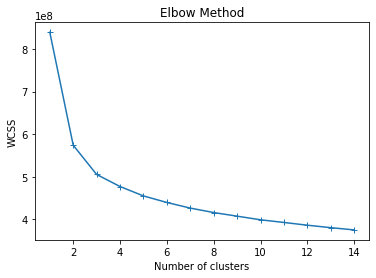

In [3]:
#un peu long
wcss=[]
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(user_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss,marker='+')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Elbow method : the optimal number is k=3

Verification with silhouette methode :

In [13]:
#NE PAS RUN : tres tres long
#kmeans = KMeans(n_clusters=2, random_state=0).fit(user_matrix)
#labels = kmeans.labels_
#s1 = silhouette_score(user_matrix, labels)
#s1

0.6710904937285531

In [14]:
# NE PAS RUN : tres tres long
#kmeans = KMeans(n_clusters=3, random_state=0).fit(user_matrix)
#labels = kmeans.labels_
#s2 = silhouette_score(user_matrix, labels)
#s2

0.5245359402930275

Silhouette method actually gives 2

## Cluster sizes

In [6]:
def get_cluster_size(clustering, nb_clusters,matrix=user_matrix) :
    for k in range(nb_clusters):
        number_users_in_cluster = 0.
        for user_index in range(1,len(matrix)) :
            if kmeans.labels_[user_index]==k :
                number_users_in_cluster+=1
        print(number_users_in_cluster)

In [7]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(user_matrix)
get_cluster_size(kmeans, 2)

186943.0
19265.0


In [8]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(user_matrix)
get_cluster_size(kmeans, 3)

167141.0
32179.0
6888.0


Clusters are very inequal, this clustering is not relevant.

## Clustering avec contrainte sur clusters size

In [3]:
import constrained_kmeans as cons

In [ ]:
#ne pas run : tres tres long
(C,M,f) = cons.constrained_kmeans(user_matrix, [92794,92794], maxiter=50)

Way too long to run (more than 6hours), never finished

## Dimensionnality reduction

https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/

In [9]:
user_matrix = np.array(user_matrix)

In [10]:
row_sums = user_matrix.sum(axis=1) #Normalize on the rows (rows_sum -> 1)
norm_matrix = user_matrix / row_sums[:, np.newaxis]

In [11]:
pca = PCA(random_state=0) 
pca.fit(norm_matrix)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
    svd_solver='auto', tol=0.0, whiten=False)

In [12]:
reduc_matrix = pca.transform(user_matrix)

Determine the right number of dimensions as a trade-off between number of dimensions and loss of variance.

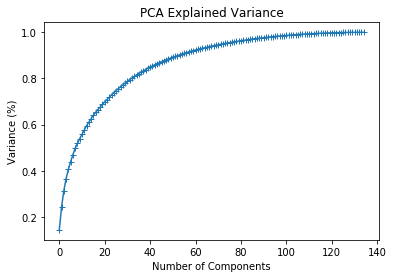

In [13]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='+')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA Explained Variance')
plt.show()

dimension choosen at the elbow : dim=30

In [14]:
pca = PCA(n_components=30, random_state=0)
reduc_matrix = pca.fit_transform(norm_matrix)

In [15]:
reduc_matrix.shape

(206209, 30)

Determine the right number of clusters (k)

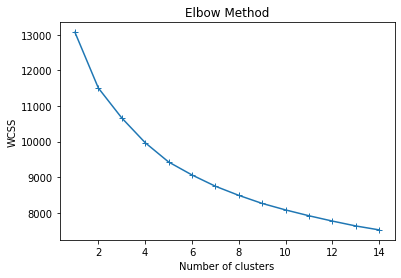

In [16]:
#un peu long
wcss=[]
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(reduc_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss, marker='+')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

optimal k is 5 with this method

In [17]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(reduc_matrix)

In [18]:
get_cluster_size(kmeans, 5, reduc_matrix)

5349.0
38473.0
55557.0
7938.0
98891.0


That's better : 3 pretty big clusters !